In [381]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
import random
import matplotlib.pyplot as plt
import glob
import numpy as np
import cv2
import os
from collections import namedtuple
%matplotlib inline

### 클래스(label) 확인

In [382]:
labels = []
for folder in glob.glob('./data/*') :
    label = folder.split('/')[-1]
    # print(label)
    labels.append(label)
print(labels)

['70', 'no_parking', 'no_parking_stop', '50', '60', '30']


In [383]:
# 클래스 개수
N_CLASSES = len(labels)
# input image size
RESIZED_IMAGE = (28, 28)

In [384]:
img_cnt = []
for label in labels :
    # print('./data/{}/*.jpg'.format(label))
    cnt = 0
    for file in glob.glob('./data/{}/*.jpg'.format(label)) :
        cnt += 1
    img_cnt.append(cnt)

In [385]:
img_cnt

[660, 189, 304, 750, 480, 730]

In [386]:
# 클래스별 이미지 개수
labels_cnt = {}
for label in labels :
    cnt = 0
    for file in glob.glob('./data/{}/*.jpg'.format(label)) :
        cnt += 1
    labels_cnt[label] = cnt

In [387]:
labels_cnt

{'70': 660,
 'no_parking': 189,
 'no_parking_stop': 304,
 '50': 750,
 '60': 480,
 '30': 730}

In [388]:
LABELS = {}
for label, i in zip(labels, range(0, N_CLASSES)) :
    LABELS[label] = i

In [389]:
LABELS

{'70': 0, 'no_parking': 1, 'no_parking_stop': 2, '50': 3, '60': 4, '30': 5}

In [390]:
LABELS_IDX = {}
for i, label in zip(range(0, N_CLASSES), labels) :
    LABELS_IDX[i] = label

In [391]:
LABELS_IDX

{0: '70', 1: 'no_parking', 2: 'no_parking_stop', 3: '50', 4: '60', 5: '30'}

### 데이터셋 만들기

In [392]:
Dataset = namedtuple('Dataset', ['X', 'y'])
print(Dataset)

<class '__main__.Dataset'>


In [393]:
# 텐서플로우에 맞는 이미지 텐서 포맷 : [?, ?, ?, ?]
# 차원 확장
def to_tf_format(imgs) :
    return np.stack([img[:, :, np.newaxis] for img in imgs], axis = 0).astype(np.float32)

In [394]:
# 한 경로에 주어진 모든 이미지를 읽어서
# 그 이미지를 미리 정의한 형상으로 크기 재조정
# 회색조로 변환
# 레이블 원-핫 인코딩

def read_dataset(root_path, labels_arr, resize_to) :
    images = []
    labels = []
    
    for label_name in labels_arr :
        # 'data/no_parking/'
        full_path = root_path + '/' + label_name + '/'
        
        for img in glob.glob(full_path + '*.jpg') :
            image = cv2.imread(img).astype(np.float32)
            # 회색조로 변환
            image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)[:, :, 0]
            # 크기 조정
            if resize_to : 
                image = cv2.resize(image, resize_to)
            
            # 라벨
            # 원-핫 인코딩
            label = np.zeros((N_CLASSES, ), dtype = np.float32)
            label[LABELS[label_name]] = 1.0
            
            images.append(image.astype(np.float32))
            labels.append(label)
            
    return Dataset(X = to_tf_format(images).astype(np.float32), y = np.matrix(labels).astype(np.float32))

In [395]:
dataset = read_dataset('data', labels, RESIZED_IMAGE)
print(dataset.X.shape)
print(dataset.y.shape)

(3113, 28, 28, 1)
(3113, 6)


In [396]:
print(dataset.X.shape, dataset.X[0, :, :, :].shape)

(3113, 28, 28, 1) (28, 28, 1)


In [397]:
print((dataset.X[0, :, :, :].reshape(RESIZED_IMAGE)).shape)

(28, 28)


[[1. 0. 0. 0. 0. 0.]]


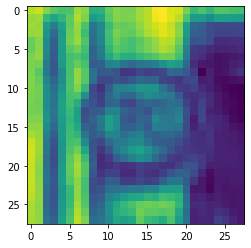

In [398]:
# 첫번째 표본
plt.imshow(dataset.X[0, :, :, :].reshape(RESIZED_IMAGE))
# 레이블
print(dataset.y[0, :])

[[0. 0. 0. 0. 0. 1.]]


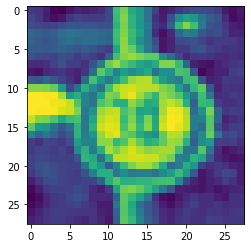

In [399]:
# 마지막 표본
plt.imshow(dataset.X[-1, :, :, :].reshape(RESIZED_IMAGE))
# 레이블
print(dataset.y[-1, :])

In [400]:
# train/test 데이터셋 분류
from sklearn.model_selection import train_test_split

idx_train, idx_test = train_test_split( range(dataset.X.shape[0]), test_size = 0.25, random_state = 101 )

In [401]:
# idx_train

In [402]:
# idx_test

In [403]:
len(idx_train), len(idx_test)

(2334, 779)

In [404]:
X_train = dataset.X[idx_train, :, :, :]
X_test = dataset.X[idx_test, :, :, :]
y_train = dataset.y[idx_train, :]
y_test = dataset.y[idx_test, :]

In [405]:
y_train, len(y_train)

(matrix([[0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0.],
         ...,
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0.]], dtype=float32), 2334)

In [406]:
y_test, len(y_test)

(matrix([[1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0.]], dtype=float32), 779)

In [407]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2334, 28, 28, 1)
(779, 28, 28, 1)
(2334, 6)
(779, 6)


In [408]:
# 훈련 데이터의 미니배치 생성

def minibatcher(X, y, batch_size, shuffle) :
    assert X.shape[0] == y.shape[0]
    n_samples = X.shape[0]
    
    if shuffle :
        idx = np.random.permutation(n_samples)
    else :
        idx = list(range(n_samples))
        
    for k in range(int(np.ceil(n_samples / batch_size))) :
        from_idx = k * batch_size
        to_idx = (k+1) * batch_size
        yield X[idx[from_idx:to_idx], :, :, :], y[idx[from_idx:to_idx], :]

In [409]:
for mb in minibatcher(X_train, y_train, 1000, True) :
    print(mb[0].shape, mb[1].shape)

(1000, 28, 28, 1) (1000, 6)
(1000, 28, 28, 1) (1000, 6)
(334, 28, 28, 1) (334, 6)


### 모델 구성

In [410]:
# optimizer : AdamOptimizer

In [411]:
# hyperparameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [412]:
N_CLASSES

6

In [413]:
# 모델 클래스 생성

class Model :
    
    def __init__(self, sess, name) :
        self.sess = sess
        self.name = name
        self._build_net()
        
    def _build_net(self) :
        with tf.variable_scope(self.name) :

            # dropout rate
            # 0.7 ~ 0.5 on training, but should be 1 for testing
            # self.keep_prob = tf.placeholder(tf.float32)
            self.training = tf.placeholder(tf.bool)

            # input placeholders
            self.X = tf.placeholder(tf.float32, shape = (None, RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1))
            self.y = tf.placeholder(tf.float32, shape = (None, N_CLASSES))

            # Layer1
            conv1 = tf.layers.conv2d(inputs = self.X, filters = 32, kernel_size = [3, 3], padding = 'SAME', activation = tf.nn.relu)
            pool1 = tf.layers.max_pooling2d(inputs = conv1, pool_size = [2, 2], padding = 'SAME', strides = 2)
            dropout1 = tf.layers.dropout(inputs = pool1, rate = 0.3, training = self.training)

            # Layer2
            conv2 = tf.layers.conv2d(inputs = dropout1, filters = 64, kernel_size = [3, 3], padding = 'SAME', activation = tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(inputs = conv2, pool_size = [2, 2], padding = 'SAME', strides = 2)
            dropout2 = tf.layers.dropout(inputs = pool2, rate = 0.3, training = self.training)

            # Layer3
            conv3 = tf.layers.conv2d(inputs = dropout2, filters = 128, kernel_size = [3, 3], padding = 'SAME', activation = tf.nn.relu)
            pool3 = tf.layers.max_pooling2d(inputs = conv3, pool_size = [2, 2], padding = 'SAME', strides = 2)
            dropout3 = tf.layers.dropout(inputs = pool3, rate = 0.3, training = self.training)

            # Dense Layer with Relu
            flat = tf.reshape(dropout3, [-1, 128 * 4 * 4])
            dense4 = tf.layers.dense(inputs = flat, units = 625, activation = tf.nn.relu)
            dropout4 = tf.layers.dropout(inputs = dense4, rate = 0.5, training = self.training)

            # Logits (no activation) Layer
            self.logits = tf.layers.dense(inputs = dropout4, units = N_CLASSES)
            # self.sm_logits = tf.nn.softmax(self.logits)

            # define cost/loss & optimizer
            self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.y))
            self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)

            correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            
    def train(self, X_data, y_data, training = True) :
        return self.sess.run([self.cost, self.optimizer], feed_dict = {self.X : X_data, self.y : y_data, self.training : training})
            
    def predict(self, X_test, training = False) :
        return self.sess.run(self.logits, feed_dict = {self.X : X_test, self.training : training})
        
    def get_accuracy(self, X_test, y_test, training = False) :
        return self.sess.run(self.accuracy, feed_dict = {self.X : X_test, self.y : y_test, self.training : training})

In [414]:
tf.reset_default_graph()

### 모델 학습 및 저장

In [415]:
CHECK_POINT_DIR = './model.ckpt'
if not os.path.exists(CHECK_POINT_DIR) :
    os.makedirs(CHECK_POINT_DIR)

In [416]:
# initialize
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
m1 = Model(sess, "m1")
sess.run(tf.global_variables_initializer())

In [417]:
# save model
saver = tf.train.Saver()

In [418]:
for mb in minibatcher(X_train, y_train, batch_size, True) :
    print(mb[0].shape, mb[1].shape)

(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(100, 28, 28, 1) (100, 6)
(34, 28, 28, 1) (34, 6)


In [419]:
# for epoch in range(max_epochs):
#     print("Epoch=", epoch)
#     tf_score = []

#     for mb in minibatcher(X_train, y_train, batch_size, True) :
#         # print(mb)
#         tf_output = session.run([optimizer, loss], 
#                                             feed_dict = {in_X_tensors_batch : mb[0], 
#                                                               in_y_tensors_batch : mb[1],
#                                                               is_training : True})

#         tf_score.append(tf_output[1])
#     print(" train_loss_score=", np.mean(tf_score))

In [420]:
# train
for epoch in range(training_epochs) :
    print("Epoch = ", epoch)
    cost = []
    # total_batch = int(len(idx_train) / batch_size)
    
    for mb in minibatcher(X_train, y_train, batch_size, True) :
        c, _ = m1.train(mb[0], mb[1])
        # avg_cost += c / total_batch
        cost.append(c)
    # print('Epoch : ', '%04d' % (epoch + 1), 'cost = ', '{:.9f}'.format(avg_cost))
    print('cost = ', np.mean(cost))

Epoch =  0
cost =  12.042949
Epoch =  1
cost =  1.7338486
Epoch =  2
cost =  1.6838955
Epoch =  3
cost =  1.6443996
Epoch =  4
cost =  1.6082834
Epoch =  5
cost =  1.5707575
Epoch =  6
cost =  1.5522329
Epoch =  7
cost =  1.5289235
Epoch =  8
cost =  1.4855719
Epoch =  9
cost =  1.472524
Epoch =  10
cost =  1.4509937
Epoch =  11
cost =  1.3934907
Epoch =  12
cost =  1.401502
Epoch =  13
cost =  1.3533959
Epoch =  14
cost =  1.3536626


In [421]:
saver.save(sess, CHECK_POINT_DIR + '/model')
print('Trained Model Saved.')

Trained Model Saved.


In [422]:
checkpoint = tf.train.get_checkpoint_state(CHECK_POINT_DIR)

In [423]:
print(checkpoint)

model_checkpoint_path: "./model.ckpt/model"
all_model_checkpoint_paths: "./model.ckpt/model"



In [424]:
print(checkpoint.model_checkpoint_path)

./model.ckpt/model


### 예측

In [425]:
print(m1.predict(X_test))
# argmax

[[ 0.7613411  -1.5820392  -1.2711114   1.8036005   0.34067672  1.3355687 ]
 [-0.27635512 -0.31923607 -0.8668401   0.5529812   0.2256749   0.34714302]
 [-0.19533697 -0.1620249   0.23486826  0.31592825 -0.23467734  0.3810448 ]
 ...
 [ 0.3599037  -0.72156346 -0.5375101   0.283992    0.36234605  0.05460368]
 [ 0.41375402 -0.67032456 -0.40155527  0.14774507  0.44371957  0.04435586]
 [ 1.0222238  -3.5286634  -3.8428066   1.896579    3.1916013   0.28566262]]


In [426]:
len(m1.predict(X_test))

779

In [427]:
len(sess.run(tf.argmax(m1.predict(X_test), 1)))

779

In [428]:
# list(sess.run(tf.argmax(m1.predict(X_test), 1)))

In [429]:
pred_num = list(sess.run(tf.argmax(m1.predict(X_test), 1)))
pred_name = []
for num in pred_num :
    pred_name.append(LABELS_IDX[num])

In [430]:
# pred_name

In [431]:
# 랜덤 예측
# import random
# r = random.randint(0, len(idx_test)-1)

In [432]:
# Test model and check accuracy
print('accuracy = ', m1.get_accuracy(X_test, y_test))

accuracy =  0.49422336


### 시각화

In [433]:
# 혼동행렬

In [434]:
sess.close()

In [ ]:
# tf.reset_default_graph()

### 실시간 영상에 분류 결과 나타내기

In [435]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [436]:
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [437]:
sess.run(tf.global_variables_initializer())

In [438]:
print(checkpoint.model_checkpoint_path + '.meta')

./model.ckpt/model.meta


In [439]:
# load a trained model
saver = tf.train.import_meta_graph(checkpoint.model_checkpoint_path + '.meta')

In [440]:
saver.restore(sess, checkpoint.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ./model.ckpt/model


In [ ]:
# print(checkpoint)
# print(checkpoint.model_checkpoint_path)

# if checkpoint and checkpoint.model_checkpoint_path :
#     try : 
#         saver.restore(sess, checkpoint.model_checkpoint_path)
#         print('Successfully loaded : ', checkpoint.model_checkpoint_path)
#     except :
#         print("Error on loading old network weights")
# else :
#     print("Could not find old network weights")

In [441]:
m2 = Model(sess, "m2")

In [442]:
print('accuracy = ', sess.run(m2.get_accuracy(X_test, y_test)))

FailedPreconditionError: Attempting to use uninitialized value m2/conv2d/kernel
	 [[node m2/conv2d/kernel/read (defined at <ipython-input-413-ad51d7a85b4c>:23) ]]

Original stack trace for 'm2/conv2d/kernel/read':
  File "/home/team2/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/team2/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/team2/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/team2/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/team2/anaconda3/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
    self._run_once()
  File "/home/team2/anaconda3/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
    handle._run()
  File "/home/team2/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2880, in _run_cell
    return runner(coro)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3057, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3248, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/team2/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-441-ba14269a5e9e>", line 1, in <module>
    m2 = Model(sess, "m2")
  File "<ipython-input-413-ad51d7a85b4c>", line 8, in __init__
    self._build_net()
  File "<ipython-input-413-ad51d7a85b4c>", line 23, in _build_net
    conv1 = tf.layers.conv2d(inputs = self.X, filters = 32, kernel_size = [3, 3], padding = 'SAME', activation = tf.nn.relu)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/layers/convolutional.py", line 424, in conv2d
    return layer.apply(inputs)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1479, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/layers/base.py", line 537, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 591, in __call__
    self._maybe_build(inputs)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1881, in _maybe_build
    self.build(input_shapes)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/convolutional.py", line 165, in build
    dtype=self.dtype)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/layers/base.py", line 450, in add_weight
    **kwargs)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 384, in add_weight
    aggregation=aggregation)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/tracking/base.py", line 663, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 1496, in get_variable
    aggregation=aggregation)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 1239, in get_variable
    aggregation=aggregation)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 562, in get_variable
    aggregation=aggregation)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 514, in _true_getter
    aggregation=aggregation)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 929, in _get_single_variable
    aggregation=aggregation)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 259, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 220, in _variable_v1_call
    shape=shape)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 198, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 2511, in default_variable_creator
    shape=shape)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 263, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 1568, in __init__
    shape=shape)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 1755, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 86, in identity
    ret = gen_array_ops.identity(input, name=name)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4253, in identity
    "Identity", input=input, name=name)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/team2/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
#############################################################################

In [ ]:
# 영상 경로 설정
video_path = './video_data/video1.mp4'
cap = cv2.VideoCapture(video_path)

video_file = video_path.split('/')[-1]
video_name = video_file.split('.')[0]

# 커널 생성
kernel1 = np.ones((2, 2), np.uint8)
kernel2 = np.ones((4, 4), np.uint8)

# 프레임 이동
# frame_move = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) // 2)
# cap.set(cv2.CAP_PROP_POS_FRAMES, frame_move)

while cap.isOpened() :
    ret, img = cap.read()
    
    if ret is False :
        break
        
    # 이미지 크기 변경
    img = cv2.resize(img, (img.shape[1]//2, img.shape[0]//2), interpolation = cv2.INTER_AREA)
    
    ######### 1. 표지판 검출 #########
    
    ## 1-1. 표지판 ROI 생성
    img_sign = np.zeros(img.shape, img.dtype)
    img_sign[0 : img.shape[0]*11//20, : ] = img[0 : img.shape[0]*11//20 ,  : ]
       
    ## 1-2. 붉은색 검출
    # 1) 색 공간 변환(BGR2YUV) -> 붉은색 계열 검출
    yuv_sign = cv2.cvtColor(img_sign, cv2.COLOR_BGR2YUV)
    yuv_sign[yuv_sign[:, :, 2]<135] = 0 # V 채널
    yuv_sign[yuv_sign[:, :, 1]<110] = 0 # U 채널
    yuv_sign[yuv_sign[:, :, 0]>225] = 0 # 밝기
    # V 채널 이진화 
    th, sign_v_bin = cv2.threshold(yuv_sign[ : , : , 2], 140, 255, cv2.THRESH_BINARY)
    erosion_sign_v_bin = cv2.erode(sign_v_bin, kernel1, iterations = 1) # 침식
    dilation_sign_v_bin = cv2.dilate(erosion_sign_v_bin, kernel2, iterations = 1) # 팽창
    
    # 2) 캐니 엣지 -> 조명 영향 제거
    sign_edge = cv2.Canny(img_sign, 100, 200)
    dilation_sign_edge = cv2.dilate(edge, kernel1, iterations = 1) # 팽창
    erosion_sign_edge = cv2.erode(dilation_edge, kernel1, iterations = 1) # 침식
    
    sign_red = cv2.bitwise_and(dilation_sign_v_bin, dilation_sign_v_bin, mask = erosion_sign_edge)
    
    ## 1-3. 원 검출
    # 1) 컨투어
    # RETR_EXTERNAL / RETR_TREE / RETR_LIST / RETR_CCOMP
    _, contours, hierarchy = cv2.findContours(sign_red, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    mask_contours = np.zeros(sign_red.shape, sign_red.dtype)
    
    for contour in contours :
        epsilon = 0.005 * cv2.arcLength(contour, True)
        # 근사 컨투어
        approx = cv2.approxPolyDP(contour, epsilon, closed = True)
        cv2.drawContours(mask_contours, [approx], -1, 255, 2)
    
    # 2) 객체 검출
    _, _, stats, centroids = cv2.connectedComponentsWithStats(mask_contours)    
    # cv2.imshow('mask_contours', mask_contours)
    
    for idx, centroid in enumerate(centroids) :
        if stats[idx][0] == 0 and stats[idx][1] == 0 :
            continue
        if np.any(np.isnan(centroid)) :
            continue
            
        x, y, w, h, area = stats[idx]
        centerX, centerY = int(centroid[0]), int(centroid[1])
        
        if area<1700 and area>100 and abs(w-h)< 5 :
            try : 
                detected_img = img[y-5 : y+h+5,  x-5 : x+w+5]
                gray_detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2GRAY)
                
                # 3) 허프 원 검출
                circles = cv2.HoughCircles(gray_detected_img, cv2.HOUGH_GRADIENT, 1, 100, param1=200, param2=40, minRadius=3, maxRadius=38)
                if circles is not None :
                    circles = np.uint16(np.around(circles))
                   
                    for i in circles[0, :] :                      
                        frame = img[y-5 : y+h+5,  x-5 : x+w+5]
##############################################################################################                        
                        # bgr -> rgb 로 배열순서 변경
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        # 리사이즈 : 64 * 64
                        frame = cv2.resize(frame, (64, 64))
                        
                        # 예측
                        preds = model.predict(np.expand_dims(frame, axis=0))[0]
                        # 레이블 확인
                        label = lb.classes_[np.argmax(preds)]
##############################################################################################                        
                        text = "{}".format(label)
                        cv2.putText( img, text, ( x, y + 100 ), cv2.FONT_HERSHEY_SIMPLEX, 1.0, ( 0, 255, 0 ), 5)
                        cv2.rectangle(img, (x-5, y-5), (x+w+5, y+h+5), (0, 0, 255), 2)
            except : 
                continue
    
    ######### 2. 차선 검출 #########
    
    ## 2-1. 차선 ROI 생성
    img_road = np.zeros(img.shape, img.dtype)
    img_road[0 : img.shape[0]*11//20, : ] = img[0 : img.shape[0]*11//20 ,  : ]    
    
    ###############################
    
    cv2.imshow(video_name, img)
    
    if cv2.waitKey(1) == 27 :
        cap.release()
        cv2.destroyAllWindows()
    
cap.release()
cv2.destroyAllWindows()